In [ ]:
""" BLOCK 1 - MANUALLY CLASSIFY ICE VS WATER IMAGES """
import os
import shutil
from pathlib import Path
from datetime import datetime

# set base path here, build folder structure
base_dir = Path(r"E:\planetscope_lake_ice\Data\Input\Machine Learning - Sentinel Samples for RF\YF")
rgb_dir = base_dir / "RGB_JPEGs"
for folder in ["_WATER", "_ICE"]:
    (base_dir / folder).mkdir(exist_ok=True)
breakup_dir = rgb_dir / "Breakup"
freezeup_dir = rgb_dir / "Freezeup"

breakup_dir.mkdir(exist_ok=True)
freezeup_dir.mkdir(exist_ok=True)

# threshold for sorting 
threshold_date = datetime.strptime("0815", "%m%d").timetuple().tm_yday  # August 15 as day of year cutoff to split into freezeup vs breakup

# iterate through all JPG files and classify 
for img_path in rgb_dir.glob("*.jpg"):
    # Example filename: S2A_6WWU_20190428_1_L2A_RGB.jpg
    # Extract date pattern (8 digits)
    parts = img_path.stem.split('_')
    date_strs = [p for p in parts if len(p) == 8 and p.isdigit()]
    if not date_strs:
        print(f"Could not find date in {img_path.name}, skipping.")
        continue

    date_str = date_strs[0]
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:8])

    file_date = datetime(year, month, day)
    day_of_year = file_date.timetuple().tm_yday

    if day_of_year < threshold_date:
        dest_folder = breakup_dir
    else:
        dest_folder = freezeup_dir

    # Move file
    dest_path = dest_folder / img_path.name
    shutil.move(str(img_path), dest_path)
    print(f"Moved {img_path.name} to {dest_folder.name}")

print("Sorting complete.")
print("Folders _WATER and _ICE created in base study site folder.")

Sorting complete.
Folders _WATER and _ICE created in base study site folder.


In [1]:
""" BLOCK 2 - SAMPLE PIXELS FROM EACH CLASSIFIED LAKE INTO PARQUET FILE """

import os
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import box, mapping
from tqdm import tqdm
import pyarrow.parquet as pq
import pyarrow as pa
from numba import njit

# Numba helpers
SCL_INVALID_CODES = np.array([0, 1, 2, 3, 7, 8, 9, 10], dtype=np.uint8)

@njit(parallel=True, fastmath=True)
def valid_mask_from_scl_numba(scl, nodata_val, invalid_codes):
    mask = np.ones(scl.shape, dtype=np.bool_)
    for i in range(scl.shape[0]):
        for j in range(scl.shape[1]):
            val = scl[i, j]
            if val == nodata_val:
                mask[i, j] = False
                continue
            for code in invalid_codes:
                if val == code:
                    mask[i, j] = False
                    break
    return mask


def sample_valid_pixels(valid_mask, n, seed=None):
    """Fast pixel sampling using NumPy."""
    if seed is not None:
        np.random.seed(seed)
    ys, xs = np.nonzero(valid_mask)
    if len(ys) == 0:
        return np.empty(0, dtype=np.int64), np.empty(0, dtype=np.int64)
    if n >= len(ys):
        return ys, xs
    idx = np.random.choice(len(ys), size=n, replace=False)
    return ys[idx], xs[idx]

def generate_training_parquet(base_dir, study_site, lake_shp, out_training_path, num_samples_per_lake=5, sentinel_epsg=32606,
):
    # generate Sentinel-2 training samples with SCL values .

    site_dir = os.path.join(base_dir, study_site)
    class_folders = {
        "ice": os.path.join(site_dir, "_ICE"),
        "water": os.path.join(site_dir, "_WATER"),
    }

    # build classification table
    records = []
    for label, fdir in class_folders.items():
        for jpg_path in glob.glob(os.path.join(fdir, "*.jpg")):
            scene_name = os.path.basename(jpg_path)
            records.append({"scene_name": scene_name, "class": label})
    df_class = pd.DataFrame(records)

    # load lakes shapefile
    gdf_lakes = gpd.read_file(lake_shp).to_crs(epsg=sentinel_epsg)

    all_samples = []

    for i, rec in tqdm(df_class.iterrows(), total=len(df_class), desc="Processing scenes"):
        scene_name = rec["scene_name"]
        label = rec["class"]

        scene_token = scene_name.split("_RGB")[0]
        scene_folder = os.path.join(site_dir, scene_token)

        desired_bands = ["B02", "B03", "B04", "B08", "B11", "B12"]
        band_paths = [os.path.join(scene_folder, f"{b}.tif")
                      for b in desired_bands if os.path.exists(os.path.join(scene_folder, f"{b}.tif"))]

        scl_path = os.path.join(scene_folder, "SCL.tif")

        # use 10 m band as reference
        prefer_10m = [p for p in band_paths if any(b in p for b in ["B02", "B03", "B04", "B08"])]
        ref_band_path = prefer_10m[0] if prefer_10m else band_paths[0]
        with rasterio.open(ref_band_path) as ref_src:
            height, width = ref_src.height, ref_src.width
            transform = ref_src.transform

        # load all bands with resampling so all are same resolution for RF
        band_stack, band_names = [], []
        for bp in band_paths:
            bname = os.path.basename(bp)
            with rasterio.open(bp) as src:
                data = src.read(1, out_shape=(height, width), resampling=rasterio.enums.Resampling.nearest)
            band_stack.append(data)
            band_names.append(os.path.splitext(bname)[0])
        band_stack = np.stack(band_stack)

        # load SCL mask
        with rasterio.open(scl_path) as srcs:
            scl = srcs.read(1, out_shape=(height, width), resampling=rasterio.enums.Resampling.nearest)
            nodata_val = srcs.nodata if srcs.nodata is not None else 0

        valid_mask = valid_mask_from_scl_numba(scl.astype(np.uint8), np.uint8(nodata_val), SCL_INVALID_CODES)

        # lake sampling
        raster_bounds = box(*rasterio.transform.array_bounds(height, width, transform))
        lakes_in_scene = gdf_lakes[gdf_lakes.intersects(raster_bounds)]
        if lakes_in_scene.empty:
            continue
        geoms = [mapping(l.geometry.intersection(raster_bounds)) for _, l in lakes_in_scene.iterrows() if not l.geometry.is_empty]
        if not geoms:
            continue
        lake_mask = ~geometry_mask(geoms, transform=transform, invert=True, out_shape=(height, width))

        combined_mask = valid_mask & lake_mask
        total_samples = num_samples_per_lake * len(geoms)
        ys, xs = sample_valid_pixels(combined_mask, total_samples, seed=42)
        if len(ys) == 0:
            continue

        # create df with band values + SCL
        sample_records = []
        for y, x in zip(ys, xs):
            sample_data = {name: float(band_stack[i, y, x]) for i, name in enumerate(band_names)}
            sample_data["SCL"] = int(scl[y, x])           # <-- Include SCL value
            sample_data.update({
                "scene": scene_token,
                "label": label,
                "row": int(y),
                "col": int(x)
            })
            sample_records.append(sample_data)
        if sample_records:
            all_samples.append(pd.DataFrame(sample_records))

    # save to parquet
    df_all = pd.concat(all_samples, ignore_index=True)
    print(f"Saving {len(df_all)} samples to {out_training_path}")

    table = pa.Table.from_pandas(df_all)
    os.makedirs(os.path.dirname(out_training_path), exist_ok=True)
    pq.write_table(table, out_training_path)


output_path = r"E:\planetscope_lake_ice\Data\Input\Machine Learning - Sentinel Samples for RF\Models\YF Freezeup\YF_freezeup.parquet"


generate_training_parquet(
    base_dir=r"E:\planetscope_lake_ice\Data\Input\Machine Learning - Sentinel Samples for RF",
    study_site="YF",                                               
    lake_shp=r"E:\planetscope_lake_ice\Data\Input\Study Sites - Manual ALPOD Data\YF 50x50 km\YF Lakes from ALPOD Shapefile\YF_50x50km_lakes.shp",
    out_training_path=output_path, 
    num_samples_per_lake=5,                                        
    sentinel_epsg=32606                                             
)

Processing scenes: 100%|██████████| 15/15 [02:42<00:00, 10.84s/it]

Saving 86545 samples to E:\planetscope_lake_ice\Data\Input\Machine Learning - Sentinel Samples for RF\Models\YF Freezeup\YF_freezeup.parquet



Classes: ['ice', 'water'] -> [0, 1]

Splitting data: 80% train, 20% test...
Training samples: 69236
Test samples: 17309
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:
  max_depth: None
  max_features: sqrt
  min_samples_split: 2
  n_estimators: 500
Best CV accuracy: 0.9422987769240277
Best model CV train accuracy: 1.0
Best model CV val accuracy: 0.9422987769240277
Classification Report (Test):
              precision    recall  f1-score   support

         ice       0.93      0.95      0.94      7925
       water       0.96      0.94      0.95      9384

    accuracy                           0.94     17309
   macro avg       0.94      0.95      0.94     17309
weighted avg       0.95      0.94      0.94     17309



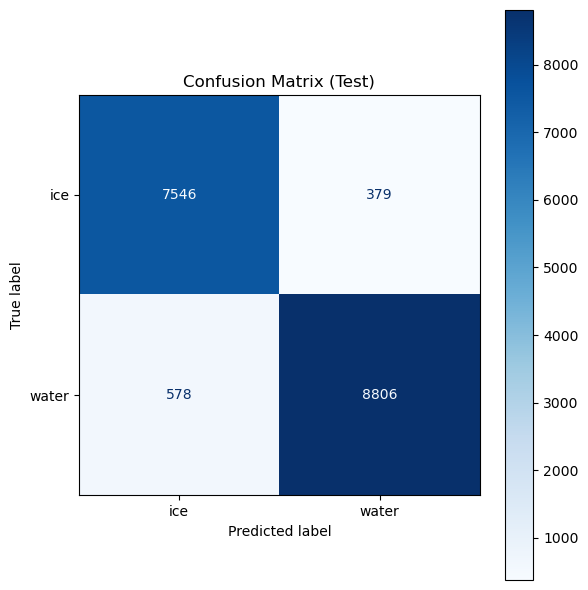

Final model trained
Feature importances:
1. B02       : 0.29284704341063555
2. B03       : 0.20692653630256336
3. SCL       : 0.14540086046971792
4. B04       : 0.12958143929257823
5. B11       : 0.08684511176406325
6. B12       : 0.07490779951506096
7. B08       : 0.06349120924538071

Feature importance plot saved


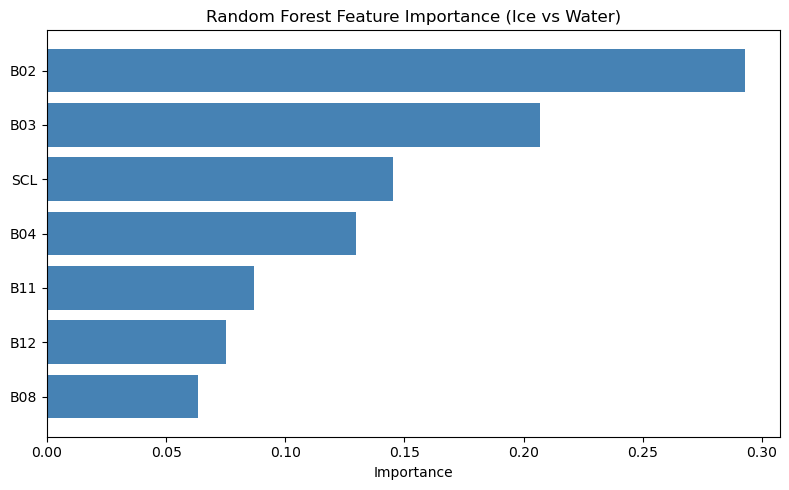

Feature importances exported to: E:\planetscope_lake_ice\Data\Input\Machine Learning - Sentinel Samples for RF\Models\YF Freezeup\YF_freezeup_feature_importance.csv
model package saved to: E:\planetscope_lake_ice\Data\Input\Machine Learning - Sentinel Samples for RF\Models\YF Freezeup\YF_freezeup_RFmodel.joblib


In [3]:
""" BLOCK 3 - RANDOM FOREST W/ CV HYPERPARAMETER TUNING """
import pandas as pd
import pyarrow.parquet as pq
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt

# input filepaths
base_dir = r"E:\planetscope_lake_ice\Data\Input\Machine Learning - Sentinel Samples for RF"
parquet_path = os.path.join(r"E:\planetscope_lake_ice\Data\Input\Machine Learning - Sentinel Samples for RF\Models\YF Freezeup\YF_freezeup.parquet") #pqt output path
model_out_path = parquet_path.replace(".parquet", "_RFmodel.joblib")
test_size = 0.2  # hold out 20% for final testing
random_state = 42

# load data
df = pq.read_table(parquet_path).to_pandas()

# drop non-feature columns to exclude from RF
feature_cols = [c for c in df.columns if c not in {"scene", "label", "row", "col"}]
X = df[feature_cols].astype(float)

# encode text labels ("ice"/"water")
le = LabelEncoder()
y = le.fit_transform(df["label"])
print(f"\nClasses: {list(le.classes_)} -> {list(range(len(le.classes_)))}")

# train/test split 
print(f"\nSplitting data: {100*(1-test_size):.0f}% train, {100*test_size:.0f}% test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# run model
rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

param_grid = {
    "n_estimators": [300,400,500],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt", "log2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# fit model with cross validation on training set
grid_search.fit(X_train, y_train)

print("Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best CV accuracy: {grid_search.best_score_}")

# check for overfitting in CV
cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_
train_score = cv_results.loc[best_idx, 'mean_train_score']
val_score = cv_results.loc[best_idx, 'mean_test_score']
print(f"Best model CV train accuracy: {train_score}")
print(f"Best model CV val accuracy: {val_score}")

# evaluate on test set, print results
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')

plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.savefig(model_out_path.replace("_RFmodel.joblib", "_confusion_matrix.png"), dpi=150)
plt.show()

# train final model on all data
final_model = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=random_state,
    n_jobs=-1
)
final_model.fit(X, y)
print("Final model trained")

#  feature importance
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_features = [feature_cols[i] for i in indices]

print("Feature importances:")
for rank, (feat, imp) in enumerate(zip(sorted_features, importances[indices]), 1):
    print(f"{rank}. {feat:10s}: {imp}")

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(sorted_features[::-1], importances[indices][::-1], color="steelblue")
ax.set_xlabel("Importance")
ax.set_title("Random Forest Feature Importance (Ice vs Water)")
plt.tight_layout()
plt.savefig(model_out_path.replace("_RFmodel.joblib", "_feature_importance.png"), dpi=150)
print(f"\nFeature importance plot saved")
plt.show()

# save to CSV
fi_df = pd.DataFrame({
    "band": feature_cols,
    "importance": final_model.feature_importances_
}).sort_values("importance", ascending=False)
fi_csv = model_out_path.replace("_RFmodel.joblib", "_feature_importance.csv")
fi_df.to_csv(fi_csv, index=False)
print(f"Feature importances exported to: {fi_csv}")

# save trained model
model_package = {
    "model": final_model,
    "label_encoder": le,
    "feature_columns": feature_cols,
    "best_params": grid_search.best_params_,
    "cv_score": grid_search.best_score_,
    "test_accuracy": (y_pred_test == y_test).mean(),
    "training_samples": len(df)
}

joblib.dump(model_package, model_out_path)
print(f"model package saved to: {model_out_path}")

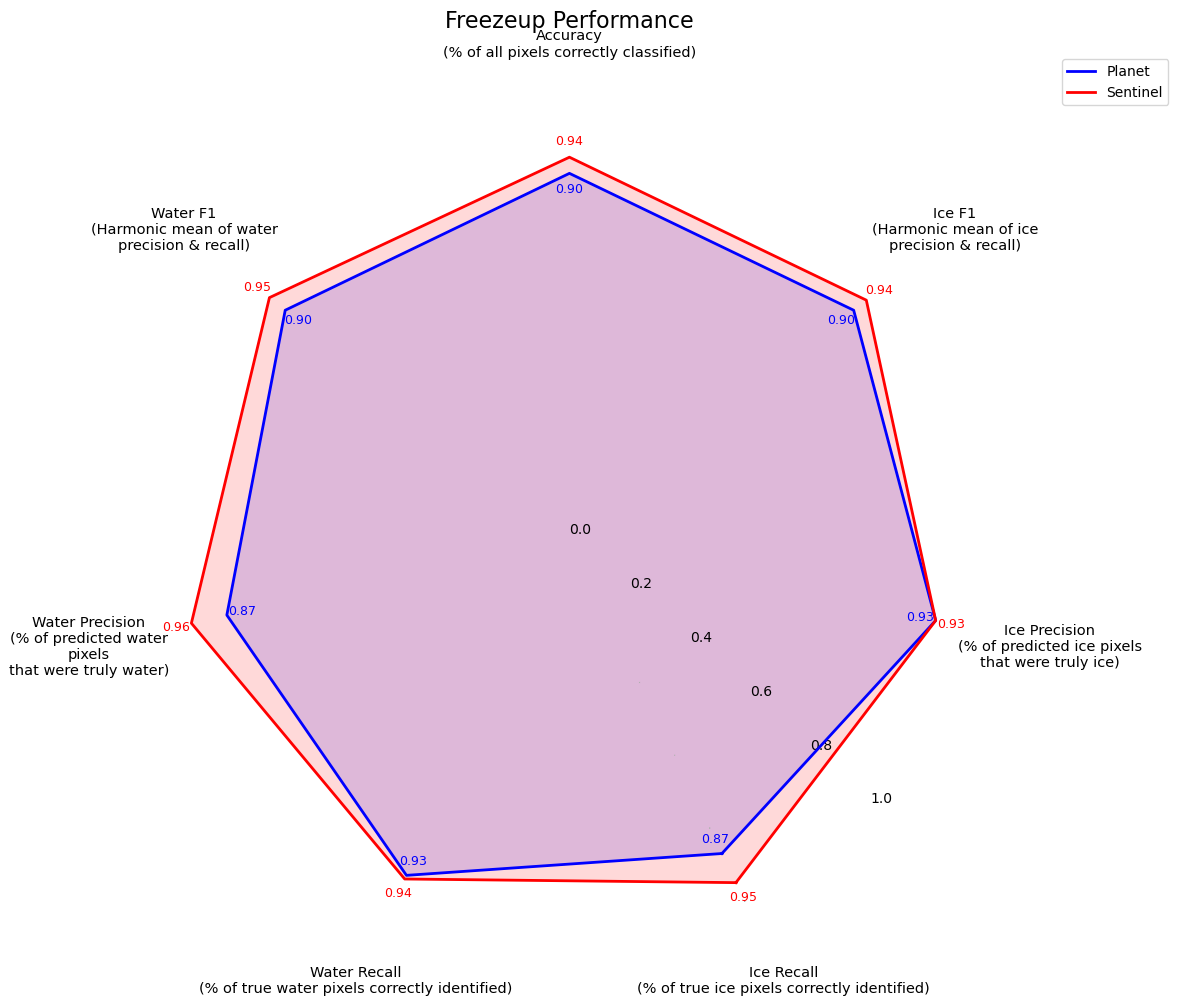

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = [
    'Ice Recall\n(% of true ice pixels correctly identified)',
    'Ice Precision\n(% of predicted ice pixels\nthat were truly ice)',
    'Ice F1\n(Harmonic mean of ice\nprecision & recall)',
    'Accuracy\n(% of all pixels correctly classified)',
    'Water F1\n(Harmonic mean of water\nprecision & recall)',
    'Water Precision\n(% of predicted water pixels\nthat were truly water)',
    'Water Recall\n(% of true water pixels correctly identified)'
]

planet = [0.87, 0.93, 0.90, 0.90, 0.90, 0.87, 0.93]
sentinel = [0.95, 0.93, 0.94, 0.94, 0.95, 0.96, 0.94]

# geometry stuff for plot
planet_vals = planet + planet[:1]
sentinel_vals = sentinel + sentinel[:1]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]


# PLOT
fig = plt.figure(figsize=(12, 12))  
ax = plt.subplot(111, polar=True)

# Rotate so "Accuracy" sits at the top
rotation = np.pi/2 - angles[3]
ax.set_theta_offset(rotation)

# Plot Planet (blue)
ax.plot(angles, planet_vals, linewidth=2, color='blue', label='Planet')
ax.fill(angles, planet_vals, alpha=0.15, color='blue')

# Plot Sentinel (red)
ax.plot(angles, sentinel_vals, linewidth=2, color='red', label='Sentinel')
ax.fill(angles, sentinel_vals, alpha=0.15, color='red')

for i, angle in enumerate(angles[:-1]):
    ax.text(angle, planet[i] - 0.04, f"{planet[i]:.2f}",
            color='blue', fontsize=9, ha='center', va='center')
    ax.text(angle, sentinel[i] + 0.04, f"{sentinel[i]:.2f}",
            color='red', fontsize=9, ha='center', va='center')

ax.set_xticks([])  # custom labels

# slightly farther radius for balanced spacing
label_radius = 1.22
for angle, label in zip(angles[:-1], labels):
    ax.text(angle, label_radius, label,
            fontsize=10.5, ha='center', va='center', wrap=True, linespacing=1.2)

ax.set_ylim(0.0, 1.0)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([f"{v:.1f}" for v in np.linspace(0, 1, 6)], fontsize=10)

plt.title("Freezeup Performance", 
          fontsize=16, y=1.12)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1))
plt.tight_layout()
plt.show()